<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load the data</a></span></li><li><span><a href="#Feature-Selection" data-toc-modified-id="Feature-Selection-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature Selection</a></span></li><li><span><a href="#Random-Forest-Modelling-Raw-features" data-toc-modified-id="Random-Forest-Modelling-Raw-features-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Random Forest Modelling Raw features</a></span></li><li><span><a href="#Random-Forest-Modelling-All-encoded-features" data-toc-modified-id="Random-Forest-Modelling-All-encoded-features-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Random Forest Modelling All encoded features</a></span></li><li><span><a href="#Grid-Search-All-encoded" data-toc-modified-id="Grid-Search-All-encoded-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Grid Search All encoded</a></span></li><li><span><a href="#Use-the-best-parameters-from-grid-search" data-toc-modified-id="Use-the-best-parameters-from-grid-search-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Use the best parameters from grid search</a></span></li><li><span><a href="#Feature-Importance" data-toc-modified-id="Feature-Importance-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Feature Importance</a></span><ul class="toc-item"><li><span><a href="#feature-importance-using-yellowbrick" data-toc-modified-id="feature-importance-using-yellowbrick-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>feature importance using yellowbrick</a></span></li></ul></li><li><span><a href="#Use-features-selection-to-refit-random-forest" data-toc-modified-id="Use-features-selection-to-refit-random-forest-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Use features selection to refit random forest</a></span></li><li><span><a href="#Feature-Importances-using-yellowbricks" data-toc-modified-id="Feature-Importances-using-yellowbricks-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Feature Importances using yellowbricks</a></span></li></ul></div>

# Imports

In [1]:
import numpy as np
import pandas as pd

import os
import time
import collections
import itertools

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# random state
random_state=100
np.random.seed=random_state
np.random.set_state=random_state

# Jupyter notebook settings for pandas
pd.set_option('display.float_format', '{:,.5f}'.format) # numbers sep by comma
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100) # None for all the rows
pd.set_option('display.max_colwidth', 200)

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [40]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8,8
plt.rcParams.update({'font.size': 16})

plt.style.use('ggplot')
%matplotlib inline

In [41]:
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.features import Rank1D
from yellowbrick.features import Rank2D

In [3]:
def multiple_linear_regression(df,features,target,model,
                               verbose=1,cv=5,test_size=0.3):
    """ Multiple Linear Regression Modelling using given model.
    
    Depends:
    Depends on function adjusted r-squared.
    
    
    Returns:
    rmse, r2_train, ar2_train, r2_test, ar2_test, cv
    """
    def adjustedR2(rsquared,nrows,kcols):
        return rsquared- (kcols-1)/(nrows-kcols) * (1-rsquared)
    
    # train test split
    train, test = train_test_split(df, test_size=0.2, random_state=100)

    # train test values
    X = df[features].values
    y = df[target].values.ravel()

    Xtrain = train[features].values
    ytrain = train[target].values.ravel()

    Xtest = test[features].values
    ytest = test[target].values.ravel()
    
    # fitting
    model.fit(Xtrain,ytrain)

    # prediction
    ypreds = model.predict(Xtest)

    # metrics
    rmse = np.sqrt(mean_squared_error(ytest,ypreds)).round(3)
    r2_train = model.score(Xtrain, ytrain).round(3)
    r2_test = model.score(Xtest, ytest).round(3)

    cv = cross_val_score(model, X, y, cv=5,n_jobs=-1,
                         verbose=verbose).mean().round(3)

    ar2_train = adjustedR2(model.score(Xtrain,ytrain),
                           Xtrain.shape[0],
                           len(features)).round(3)
    ar2_test  = adjustedR2(model.score(Xtest,ytest),
                           Xtest.shape[0] ,
                           len(features)).round(3)
    
    return (rmse, r2_train, ar2_train, r2_test, ar2_test, cv)


df_eval = pd.DataFrame({'Model': [],
                           'Details':[],
                           'Root Mean Squared Error (RMSE)':[],
                           'R-squared (training)':[],
                           'Adjusted R-squared (training)':[],
                           'R-squared (test)':[],
                           'Adjusted R-squared (test)':[],
                           '5-Fold Cross Validation':[]})

# Load the data

In [4]:
df = df = pd.read_csv('../data/processed/data_cleaned_encoded.csv')

df_raw = df.copy(deep=True)
df.drop(['id','date'],axis=1,inplace=True)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sales,age,yr_renovated2,age_after_renovation,zipcode_top10,zipcode_houses,basement_bool,renovation_bool,age_cat,age_after_renovation_cat,waterfront_0,waterfront_1,view_0,view_1,view_2,view_3,view_4,condition_1,condition_2,condition_3,condition_4,condition_5,grade_1,grade_10,grade_11,grade_12,grade_13,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,zipcode_top10_98004,zipcode_top10_98006,zipcode_top10_98033,zipcode_top10_98039,zipcode_top10_98040,zipcode_top10_98102,zipcode_top10_98105,zipcode_top10_98155,zipcode_top10_98177,zipcode_top10_others,age_cat_0,age_cat_1,age_cat_2,age_cat_3,age_cat_4,age_cat_5,age_cat_6,age_cat_7,age_cat_8,age_cat_9,age_after_renovation_cat_0,age_after_renovation_cat_1,age_after_renovation_cat_2,age_after_renovation_cat_3,age_after_renovation_cat_4,age_after_renovation_cat_5,age_after_renovation_cat_6,age_after_renovation_cat_7,age_after_renovation_cat_8,age_after_renovation_cat_9,log1p_price,log1p_sqft_living,log1p_sqft_lot,log1p_sqft_above,log1p_sqft_basement,log1p_sqft_living15,log1p_sqft_lot15
0,"221,900.00000",3,1.00000,1180,5650,1.00000,0,0,3,7,1180,0,1955,0,98178,47.51120,-122.25700,1340,5650,2014,59,1955,59,others,262,0,0,5,5,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,12.30999,7.07412,8.63959,7.07412,0.00000,7.20117,8.63959
1,"538,000.00000",3,2.25000,2570,7242,2.00000,0,0,3,7,2170,400,1951,1991,98125,47.72100,-122.31900,1690,7639,2014,63,1991,23,others,410,1,1,5,2,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,13.19562,7.85205,8.88779,7.68294,5.99396,7.43308,8.94115
2,"180,000.00000",2,1.00000,770,10000,1.00000,0,0,3,6,770,0,1933,0,98028,47.73790,-122.23300,2720,8062,2015,82,1933,82,others,283,0,0,7,7,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,12.10072,6.64769,9.21044,6.64769,0.00000,7.90875,8.99504
3,"604,000.00000",4,3.00000,1960,5000,1.00000,0,0,5,7,1050,910,1965,0,98136,47.52080,-122.39300,1360,5000,2014,49,1965,49,others,263,1,0,4,4,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,13.31133,7.58121,8.51739,6.95750,6.81454,7.21598,8.51739
4,"510,000.00000",3,2.00000,1680,8080,1.00000,0,0,3,8,1680,0,1987,0,98074,47.61680,-122.04500,1800,7503,2015,28,1987,28,others,441,0,0,2,2,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,13.14217,7.42714,8.99727,7.42714,0.00000,7.49610,8.92319


# Feature Selection

In [5]:
df.columns.values

array(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
       'long', 'sqft_living15', 'sqft_lot15', 'yr_sales', 'age',
       'yr_renovated2', 'age_after_renovation', 'zipcode_top10',
       'zipcode_houses', 'basement_bool', 'renovation_bool', 'age_cat',
       'age_after_renovation_cat', 'waterfront_0', 'waterfront_1',
       'view_0', 'view_1', 'view_2', 'view_3', 'view_4', 'condition_1',
       'condition_2', 'condition_3', 'condition_4', 'condition_5',
       'grade_1', 'grade_10', 'grade_11', 'grade_12', 'grade_13',
       'grade_3', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8',
       'grade_9', 'zipcode_top10_98004', 'zipcode_top10_98006',
       'zipcode_top10_98033', 'zipcode_top10_98039',
       'zipcode_top10_98040', 'zipcode_top10_98102',
       'zipcode_top10_98105', 'zipcode_top10_98155',
       'zipcode_t

In [6]:
df.filter(regex='_\d').columns

Index(['waterfront_0', 'waterfront_1', 'view_0', 'view_1', 'view_2', 'view_3',
       'view_4', 'condition_1', 'condition_2', 'condition_3', 'condition_4',
       'condition_5', 'grade_1', 'grade_10', 'grade_11', 'grade_12',
       'grade_13', 'grade_3', 'grade_4', 'grade_5', 'grade_6', 'grade_7',
       'grade_8', 'grade_9', 'zipcode_top10_98004', 'zipcode_top10_98006',
       'zipcode_top10_98033', 'zipcode_top10_98039', 'zipcode_top10_98040',
       'zipcode_top10_98102', 'zipcode_top10_98105', 'zipcode_top10_98155',
       'zipcode_top10_98177', 'age_cat_0', 'age_cat_1', 'age_cat_2',
       'age_cat_3', 'age_cat_4', 'age_cat_5', 'age_cat_6', 'age_cat_7',
       'age_cat_8', 'age_cat_9', 'age_after_renovation_cat_0',
       'age_after_renovation_cat_1', 'age_after_renovation_cat_2',
       'age_after_renovation_cat_3', 'age_after_renovation_cat_4',
       'age_after_renovation_cat_5', 'age_after_renovation_cat_6',
       'age_after_renovation_cat_7', 'age_after_renovation_cat_8',
  

In [7]:
df_orig = pd.read_csv('../data/raw/kc_house_data.csv',nrows=1)
df_orig.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [8]:
features_orig = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15']

cols_num = ['bedrooms', 'bathrooms',
            'sqft_living', 'sqft_lot','sqft_above','sqft_basement',
            'yr_built', 'yr_renovated',
           'lat','long',
           'sqft_living15', 'sqft_lot15', 'yr_sales']

cols_bool = ['basement_bool', 'renovation_bool']

cols_new = ['zipcode_houses']

cols_cat = [
    # waterfront
    'waterfront_0', 'waterfront_1',
    
    #view
    'view_0', 'view_1', 'view_2', 'view_3','view_4',
    
    # condition
    'condition_1', 'condition_2', 'condition_3',
    'condition_4','condition_5',
    
    # grade
    'grade_1', 'grade_10', 'grade_11', 'grade_12','grade_13',
    'grade_3', 'grade_4', 'grade_5', 'grade_6', 'grade_7','grade_8', 'grade_9',
            
    # zipcode
    'zipcode_top10_98004', 'zipcode_top10_98006',
    'zipcode_top10_98033', 'zipcode_top10_98039',
    'zipcode_top10_98040','zipcode_top10_98102',
    'zipcode_top10_98105', 'zipcode_top10_98155',
    'zipcode_top10_98177']



cols_cat_age = [ 'age_cat_0', 'age_cat_1', 'age_cat_2',
                               'age_cat_3', 'age_cat_4', 'age_cat_5',
                               'age_cat_6', 'age_cat_7', 'age_cat_8',
                               'age_cat_9']

cols_cat_agernv = [
                'age_after_renovation_cat_0','age_after_renovation_cat_1',
                'age_after_renovation_cat_2', 'age_after_renovation_cat_3',
                'age_after_renovation_cat_4', 'age_after_renovation_cat_5',
                'age_after_renovation_cat_6', 'age_after_renovation_cat_7',
                'age_after_renovation_cat_8', 'age_after_renovation_cat_9']

features_all_encoded = cols_num + cols_bool + cols_new + cols_cat + cols_cat_age + cols_cat_agernv
target = ['price']

# Random Forest Modelling Raw features

In [9]:
target = ['price']
features = features_orig


df = df_raw[features + target]

model = RandomForestRegressor(random_state=random_state)

rmse, r2_train, ar2_train, r2_test, ar2_test, cv = \
    multiple_linear_regression(df, features, target,model,
                               verbose=0,test_size=0.2)


df_eval.loc[len(df_eval)] = ['Random Forest Regressor',
                             'all orig features', rmse,r2_train,ar2_train,
                             r2_test,ar2_test,cv]


df_eval.sort_values('Adjusted R-squared (test)',ascending=False)\
  .style.background_gradient(subset=['Adjusted R-squared (test)'])

/Users/poudel/miniconda3/envs/dataSc/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
0,Random Forest Regressor,all orig features,130835,0.974,0.974,0.873,0.872,0.86


In [10]:
target = ['price']

features = features_orig

model = RandomForestRegressor(n_estimators= 50,random_state=random_state)

rmse, r2_train, ar2_train, r2_test, ar2_test, cv = \
    multiple_linear_regression(df, features, target,model,
                               verbose=0,test_size=0.2)


df_eval.loc[len(df_eval)] = ['Random Forest Regressor',
                             'all orig features n_estimators=50', rmse,r2_train,ar2_train,
                             r2_test,ar2_test,cv]


df_eval.sort_values('Adjusted R-squared (test)',ascending=False)\
  .style.background_gradient(subset=['Adjusted R-squared (test)'])

,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
1,Random Forest Regressor,all orig features n_estimators=50,125317,0.981,0.981,0.883,0.883,0.872
0,Random Forest Regressor,all orig features,130835,0.974,0.974,0.873,0.872,0.86


# Random Forest Modelling All encoded features

In [11]:
target = ['price']
features = features_all_encoded
df = df_raw[features + target]

model = RandomForestRegressor(random_state=random_state)

rmse, r2_train, ar2_train, r2_test, ar2_test, cv = \
    multiple_linear_regression(df, features, target,model,
                               verbose=0,test_size=0.2)


df_eval.loc[len(df_eval)] = ['Random Forest Regressor',
                             'all encoded features', rmse,r2_train,ar2_train,
                             r2_test,ar2_test,cv]


df_eval.sort_values('Adjusted R-squared (test)',ascending=False)\
  .style.background_gradient(subset=['Adjusted R-squared (test)'])

/Users/poudel/miniconda3/envs/dataSc/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
1,Random Forest Regressor,all orig features n_estimators=50,125317,0.981,0.981,0.883,0.883,0.872
0,Random Forest Regressor,all orig features,130835,0.974,0.974,0.873,0.872,0.86
2,Random Forest Regressor,all encoded features,132481,0.975,0.975,0.87,0.868,0.86


In [12]:
target = ['price']
features = features_all_encoded
df = df_raw[features + target]

model = RandomForestRegressor(n_estimators= 50,random_state=random_state)

rmse, r2_train, ar2_train, r2_test, ar2_test, cv = \
    multiple_linear_regression(df, features, target,model,
                               verbose=0,test_size=0.2)


df_eval.loc[len(df_eval)] = ['Random Forest Regressor',
                             'all encoded features, n_estimators=50', rmse,r2_train,ar2_train,
                             r2_test,ar2_test,cv]


df_eval.sort_values('Adjusted R-squared (test)',ascending=False)\
  .style.background_gradient(subset=['Adjusted R-squared (test)'])

,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
3,Random Forest Regressor,"all encoded features, n_estimators=50",121276,0.982,0.982,0.891,0.889,0.87
1,Random Forest Regressor,all orig features n_estimators=50,125317,0.981,0.981,0.883,0.883,0.872
0,Random Forest Regressor,all orig features,130835,0.974,0.974,0.873,0.872,0.86
2,Random Forest Regressor,all encoded features,132481,0.975,0.975,0.87,0.868,0.86


# Grid Search All encoded

Most important hyperparameters of Random Forest:

- n_estimators = n of trees
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)

In [13]:
target = ['price']
features = features_all_encoded
df = df_raw[features + target]

# train test split
train, test = train_test_split(df, test_size=0.2,
                               random_state=random_state)

# train test values
X = df[features].values
y = df[target].values.ravel()

Xtrain = train[features].values
ytrain = train[target].values.ravel()

Xtest = test[features].values
ytest = test[target].values.ravel()

In [14]:
from sklearn.model_selection import GridSearchCV

t0 = time.time()

model = RandomForestRegressor(random_state=random_state)


param_grid = [
{'n_estimators': np.arange(20,60,20),
 'max_features': [2, len(features)], 
 'max_depth': [10, 50, None],
 'bootstrap': [True, False]}
]

grid_search_forest = GridSearchCV(model,
                                  param_grid,
                                  cv=5,
                                  n_jobs=-1,
                                  scoring='neg_mean_squared_error',
                                  verbose=2)

grid_search_forest.fit(Xtrain, ytrain)

t1 = time.time() - t0
print('Time taken: {:.0f} min {:.0f} secs'.format(*divmod(t1,60)))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.9min finished


Time taken: 1 min 58 secs


# Use the best parameters from grid search

In [15]:
grid_search_forest.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
                      max_features=69, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=40,
                      n_jobs=None, oob_score=False, random_state=100, verbose=0,
                      warm_start=False)

In [16]:
grid_search_forest.best_params_

{'bootstrap': True, 'max_depth': 50, 'max_features': 69, 'n_estimators': 40}

In [17]:
target = ['price']
features = features_all_encoded
df = df_raw[features + target]

model = RandomForestRegressor(n_estimators= 40,random_state=random_state,
                              max_features=69,
                              max_depth=50, bootstrap=True)

rmse, r2_train, ar2_train, r2_test, ar2_test, cv = \
    multiple_linear_regression(df, features, target,model,
                               verbose=2,test_size=0.2)


df_eval.loc[len(df_eval)] = ['Random Forest Regressor after grid search',
                             ' all encoded features, best grid search,\
                             n_estimators=40, max_features=69, max_depth=50',
                             rmse,r2_train,ar2_train,
                             r2_test,ar2_test,cv]


df_eval.sort_values('Adjusted R-squared (test)',ascending=False)\
  .style.background_gradient(subset=['Adjusted R-squared (test)'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.2s finished


,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
3,Random Forest Regressor,"all encoded features, n_estimators=50",121276,0.982,0.982,0.891,0.889,0.87
4,Random Forest Regressor after grid search,"all encoded features, best grid search, n_estimators=40, max_features=69, max_depth=50",121702,0.981,0.981,0.89,0.888,0.868
1,Random Forest Regressor,all orig features n_estimators=50,125317,0.981,0.981,0.883,0.883,0.872
0,Random Forest Regressor,all orig features,130835,0.974,0.974,0.873,0.872,0.86
2,Random Forest Regressor,all encoded features,132481,0.975,0.975,0.87,0.868,0.86


# Feature Importance

In [18]:
importances = grid_search_forest.best_estimator_.feature_importances_
importances

array([2.74192655e-03, 6.52461883e-03, 5.18007921e-01, 1.38699937e-02,
       2.54835769e-02, 4.62482004e-03, 1.27342271e-02, 1.59266272e-03,
       1.79397409e-01, 7.05908879e-02, 4.30063724e-02, 1.43828957e-02,
       1.84385123e-03, 3.89998170e-04, 2.69831043e-04, 1.23662253e-02,
       1.40485087e-02, 1.80969621e-02, 4.76377495e-03, 3.12577404e-04,
       7.13343216e-04, 8.99152948e-04, 8.94896294e-03, 1.08122782e-04,
       2.34225164e-04, 1.28652314e-03, 8.36194392e-04, 1.09504027e-03,
       2.02047259e-09, 4.31977482e-03, 2.97704944e-03, 4.74462977e-03,
       3.32560089e-04, 7.23933839e-07, 1.25850027e-05, 8.67799688e-05,
       5.14956415e-04, 5.58210139e-03, 3.88856349e-03, 3.10753442e-03,
       4.20970555e-03, 1.03636174e-03, 1.98531117e-04, 1.69926143e-04,
       1.26626752e-03, 5.70068492e-05, 1.27688907e-04, 8.53455848e-05,
       1.08192016e-04, 4.05738749e-04, 4.76407431e-04, 3.50187037e-04,
       2.01864013e-04, 3.69848711e-04, 2.57681711e-04, 5.04764003e-04,
      

In [19]:
df_imp = pd.DataFrame({'feature': features,
                      'importance': importances})

df_imp.sort_values('importance', ascending=False)\
  .head(10).style.background_gradient(subset=['importance'])

,feature,importance
2,sqft_living,0.518008
8,lat,0.179397
9,long,0.0705909
10,sqft_living15,0.0430064
4,sqft_above,0.0254836
17,waterfront_1,0.018097
11,sqft_lot15,0.0143829
16,waterfront_0,0.0140485
3,sqft_lot,0.01387
6,yr_built,0.0127342


In [20]:
df_imp.sort_values('importance', ascending=False)\
  .head(10).style.bar(subset=['importance'],align='mid')

,feature,importance
2,sqft_living,0.518008
8,lat,0.179397
9,long,0.0705909
10,sqft_living15,0.0430064
4,sqft_above,0.0254836
17,waterfront_1,0.018097
11,sqft_lot15,0.0143829
16,waterfront_0,0.0140485
3,sqft_lot,0.01387
6,yr_built,0.0127342


## feature importance using yellowbrick

In [42]:
from yellowbrick.model_selection import FeatureImportances

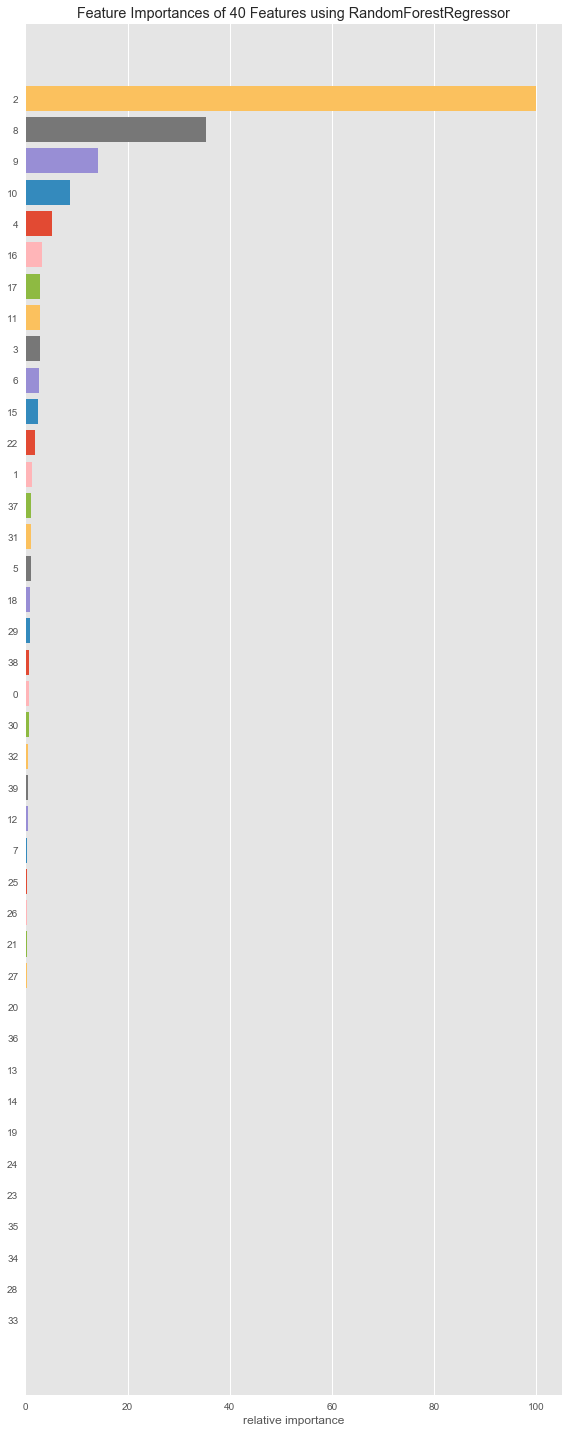

In [43]:
model = RandomForestRegressor(n_estimators= 50,random_state=random_state,
                              max_depth=50, bootstrap=True)


Xtr
plt.figure(figsize=(8,20))
viz = FeatureImportances(model)
viz.fit(Xtrain, ytrain)
viz.show()

In [22]:
topN = 10
top_cols = df_imp.head(topN)['feature'].values.tolist()
top_cols

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long']

In [23]:
df_raw.shape

(21613, 92)

# Use features selection to refit random forest

In [24]:
def grid_search_topNs():
    for topN in [10,20,30,40,50,60,70,80,90]:

        print('Running for topN = ', topN)
        top_cols = df_imp.head(topN)['feature'].values.tolist()

        features = top_cols
        target = ['price']

        df = df_raw[features + target]

        model = RandomForestRegressor(n_estimators= 40,random_state=random_state,
                                     max_depth=50, bootstrap=True)

        rmse, r2_train, ar2_train, r2_test, ar2_test, cv = \
            multiple_linear_regression(df, features, target,model,
                                       verbose=2,test_size=0.2)


        df_eval.loc[len(df_eval)] = ['Random Forest Regressor',
                                     'n_estimators = 40, max_depth = 50,\
                                     topN features = '+str(topN),
                                     rmse,r2_train,ar2_train,
                                     r2_test,ar2_test,cv]

In [25]:
topN = 40
top_cols = df_imp.head(topN)['feature'].values.tolist()

features = top_cols
target = ['price']

df = df_raw[features + target]

model = RandomForestRegressor(n_estimators= 50,random_state=random_state,
                              max_depth=50, bootstrap=True)

rmse, r2_train, ar2_train, r2_test, ar2_test, cv = \
    multiple_linear_regression(df, features, target,model,
                               verbose=2,test_size=0.2)

df_eval.loc[len(df_eval)] = ['Random Forest Regressor',
                             'n_estimators = 50, max_depth = 50,\
                             topN features = '+str(topN),
                             rmse,r2_train,ar2_train,
                             r2_test,ar2_test,cv]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.1s finished


In [26]:
df_eval.sort_values('Adjusted R-squared (test)',ascending=False)\
  .style.background_gradient(subset=['Adjusted R-squared (test)'])

,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
5,Random Forest Regressor,"n_estimators = 50, max_depth = 50, topN features = 40",121221,0.981,0.981,0.891,0.89,0.87
3,Random Forest Regressor,"all encoded features, n_estimators=50",121276,0.982,0.982,0.891,0.889,0.87
4,Random Forest Regressor after grid search,"all encoded features, best grid search, n_estimators=40, max_features=69, max_depth=50",121702,0.981,0.981,0.89,0.888,0.868
1,Random Forest Regressor,all orig features n_estimators=50,125317,0.981,0.981,0.883,0.883,0.872
0,Random Forest Regressor,all orig features,130835,0.974,0.974,0.873,0.872,0.86
2,Random Forest Regressor,all encoded features,132481,0.975,0.975,0.87,0.868,0.86


# Feature Importances using yellowbricks

In [36]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8,8
plt.rcParams.update({'font.size': 16})

plt.style.use('ggplot')
%matplotlib inline

from yellowbrick.features import Rank1D
from yellowbrick.features import Rank2D

/Users/poudel/miniconda3/envs/dataSc/lib/python3.7/site-packages/scipy/stats/morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/poudel/miniconda3/envs/dataSc/lib/python3.7/site-packages/yellowbrick/features/rankd.py:216: YellowbrickWarning: RankD plots may be clipped when using matplotlib v3.1.1, upgrade to matplotlib v3.1.2 or later to fix the plots.
  warnings.warn(msg, YellowbrickWarning)


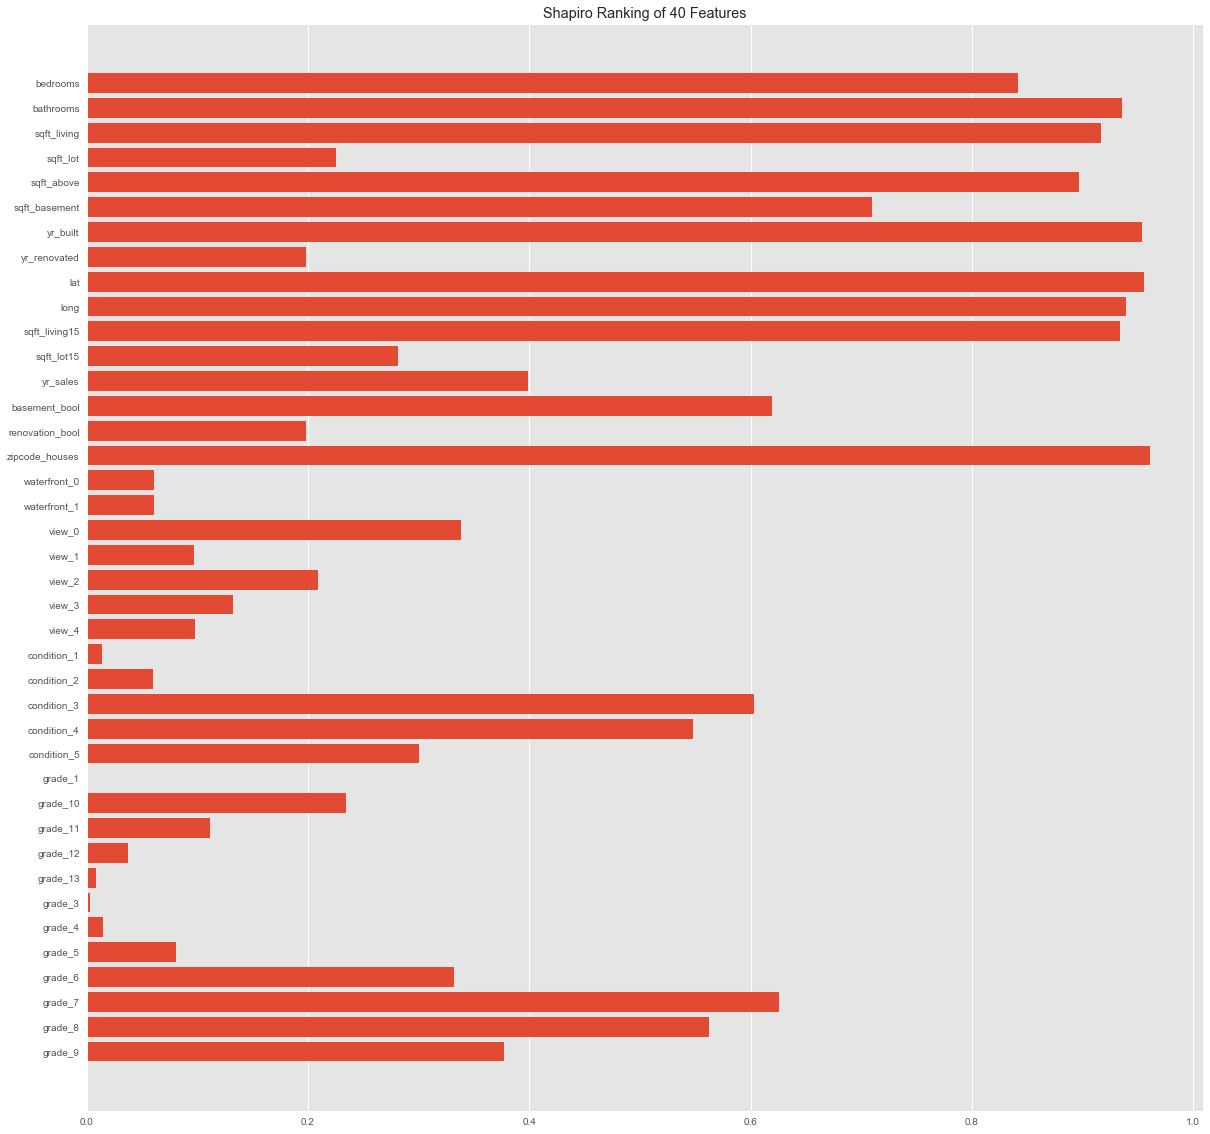

In [37]:
topN = 40
top_cols = df_imp.head(topN)['feature'].values.tolist()

features = top_cols
target = ['price']

df = df_raw[features + target]

# train test split
train, test = train_test_split(df, test_size=0.2, random_state=100)

# train test values
X = df[features].values
y = df[target].values.ravel()

Xtrain = train[features].values
ytrain = train[target].values.ravel()

Xtest = test[features].values
ytest = test[target].values.ravel()


model = RandomForestRegressor(n_estimators= 50,random_state=random_state,
                              max_depth=50, bootstrap=True)


plt.figure(figsize=(20,20))


# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank1D(features=top_cols, algorithm='shapiro') 


visualizer.fit(Xtrain, ytrain)                
visualizer.transform(Xtrain)             
visualizer.poof()

/Users/poudel/miniconda3/envs/dataSc/lib/python3.7/site-packages/yellowbrick/features/rankd.py:216: YellowbrickWarning: RankD plots may be clipped when using matplotlib v3.1.1, upgrade to matplotlib v3.1.2 or later to fix the plots.
  warnings.warn(msg, YellowbrickWarning)


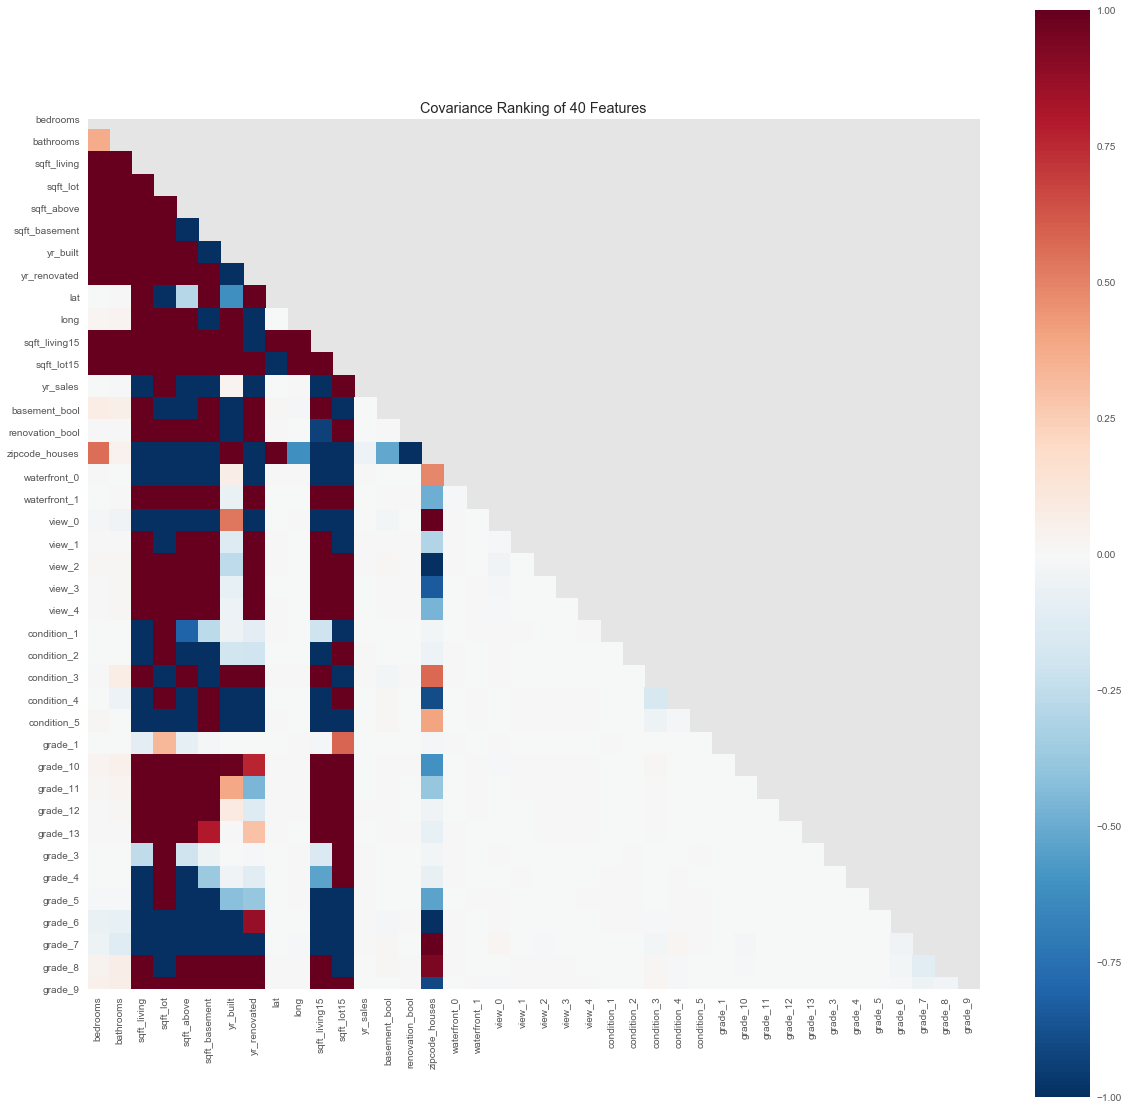

In [38]:
topN = 40
top_cols = df_imp.head(topN)['feature'].values.tolist()

features = top_cols
target = ['price']

df = df_raw[features + target]

# train test split
train, test = train_test_split(df, test_size=0.2, random_state=100)

# train test values
X = df[features].values
y = df[target].values.ravel()

Xtrain = train[features].values
ytrain = train[target].values.ravel()

Xtest = test[features].values
ytest = test[target].values.ravel()


model = RandomForestRegressor(n_estimators= 50,random_state=random_state,
                              max_depth=50, bootstrap=True)


plt.figure(figsize=(20,20))


# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(features=top_cols, algorithm='covariance') 

#visualizer = Rank2D(features=feature_names, algorithm='pearson')
visualizer.fit(Xtrain, ytrain)                
visualizer.transform(Xtrain)             
visualizer.poof()